In [5]:
import torch
from transformers import GPT2Model, GPT2Tokenizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from torch import  nn
from torch.optim import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm

In [6]:
df = pd.read_csv('bbc-text.csv')

In [7]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [8]:
df.groupby("category").describe()

text                                                            \
              count unique                                                top   
category                                                                        
business        510    503  economy  strong  in election year uk businesse...   
entertainment   386    369  ocean s twelve raids box office ocean s twelve...   
politics        417    403  super union  merger plan touted two of britain...   
sport           511    504  hantuchova in dubai last eight daniela hantuch...   
tech            401    347  california sets fines for spyware the makers o...   

                    
              freq  
category            
business         2  
entertainment    2  
politics         2  
sport            2  
tech             2

<Axes: xlabel='category'>

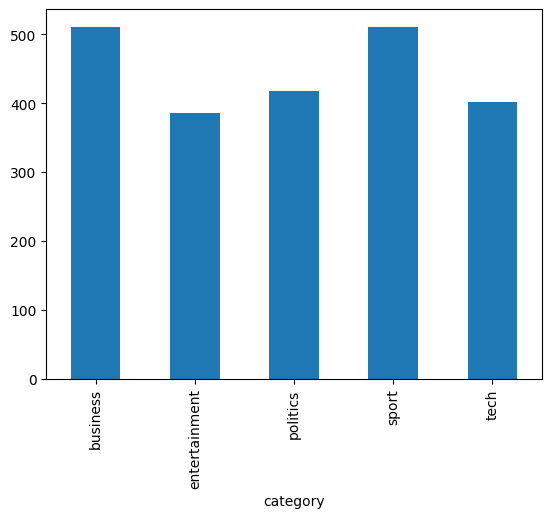

In [9]:
df.groupby("category").size().plot.bar()

#Preprocessing data (text tokenization)

In [10]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side ="left"
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [11]:
example = "I go to school"
gpt2_input = tokenizer(example, return_tensors="pt", padding="max_length",max_length=10, truncation=True)

In [12]:
print (gpt2_input["attention_mask"])

tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]])


In [13]:
print(gpt2_input["input_ids"])

tensor([[50256, 50256, 50256, 50256, 50256, 50256,    40,   467,   284,  1524]])


In [14]:
example = tokenizer.decode(gpt2_input["input_ids"][0])

In [15]:
print(example)

<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>I go to school


#Dataset class

In [16]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side ="left"
tokenizer.pad_token = tokenizer.eos_token
labels ={
    "business":0,
    "entertainment":1,
    "politics":2,
    "sport":3,
    "tech":4
}

class Dataset (torch.utils.data.Dataset):
    def __init__(self,df):
        self.df = df
        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, padding="max_length",max_length=128, truncation=True, return_tensors="pt") for text in df['text']]
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)
    def get_batch_labels(self,idx):
        return np.array(self.label[idx])
    def get_batch_texts(self,idx):
        return self.texts[idx]
    def __getitem__(self,idx):
        batch_texts = self.texts[idx]
        batch_y = self.labels[idx]
        return batch_texts, batch_y


#Split training test dataset

In [17]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])
print(len(df_train),len(df_val), len(df_test))

1780 222 223


#Model building

In [18]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)


    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [20]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

In [21]:
def trainer(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            train_accuracies.append(total_acc_train / len(train_data))
            val_accuracies.append(total_acc_val / len(val_data))
            train_losses.append(total_loss_train / len(train_data))
            val_losses.append(total_loss_val / len(val_data))
               # Plot metrics after trainin
EPOCHS = 2
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-6

trainer(model, df_train, df_val, LR, EPOCHS)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

100%|██████████| 890/890 [59:28<00:00,  4.01s/it]


Epochs: 1 | Train Loss:  0.946                 | Train Accuracy:  0.347                 | Val Loss:  0.483                 | Val Accuracy:  0.662


100%|██████████| 890/890 [59:49<00:00,  4.03s/it]


Epochs: 2 | Train Loss:  0.303                 | Train Accuracy:  0.823                 | Val Loss:  0.124                 | Val Accuracy:  0.955


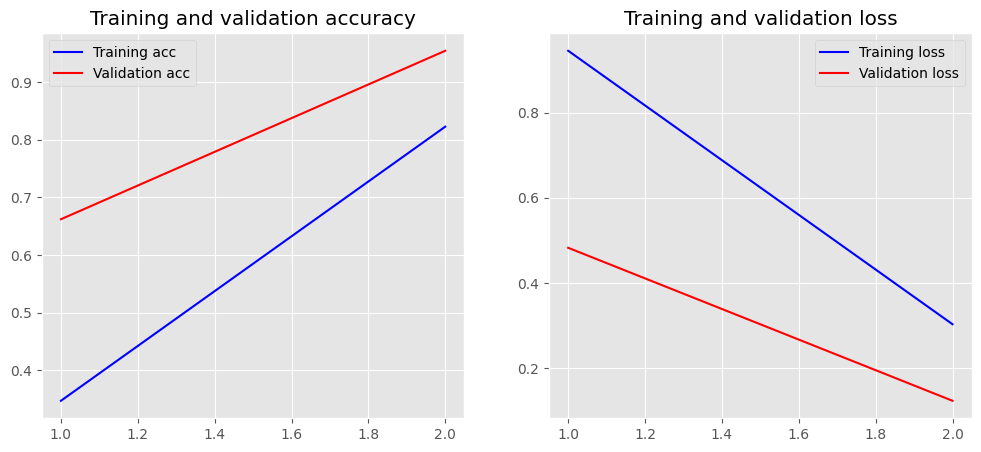

In [24]:
epochs=2
x = range(1, epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, train_accuracies, 'b', label='Training acc')
plt.plot(x, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, train_losses, 'b', label='Training loss')
plt.plot(x, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()  # Display the plot



In [25]:
def evaluate (model, test_data):
  test = Dataset(test_data)
  test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
  use_cuda = torch.cuda.is_available() # Call is_available as a function
  device = torch.device("cuda" if use_cuda else "cpu")
  if use_cuda:
    model = model.cuda()
  prediction_labels =[]
  true_labels=[]
  total_acc_test = 0
  with torch.no_grad():
    for test_input, test_label in test_dataloader:
      test_label = test_label.to(device)
      mask = test_input['attention_mask'].to(device)
      input_id = test_input['input_ids'].to(device)
      output = model(input_id, mask)
      acc = (output.argmax(dim=1) == test_label).sum().item()
      total_acc_test += acc
      true_labels += test_label.cpu().numpy().flatten().tolist()
      prediction_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
  print(f'Test Accuracy:{total_acc_test/len(test_data):.3f}')
  return true_labels, prediction_labels

In [26]:
true_labels, pred_labels = evaluate(model, df_test)

Test Accuracy:0.901


In [27]:
#s utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

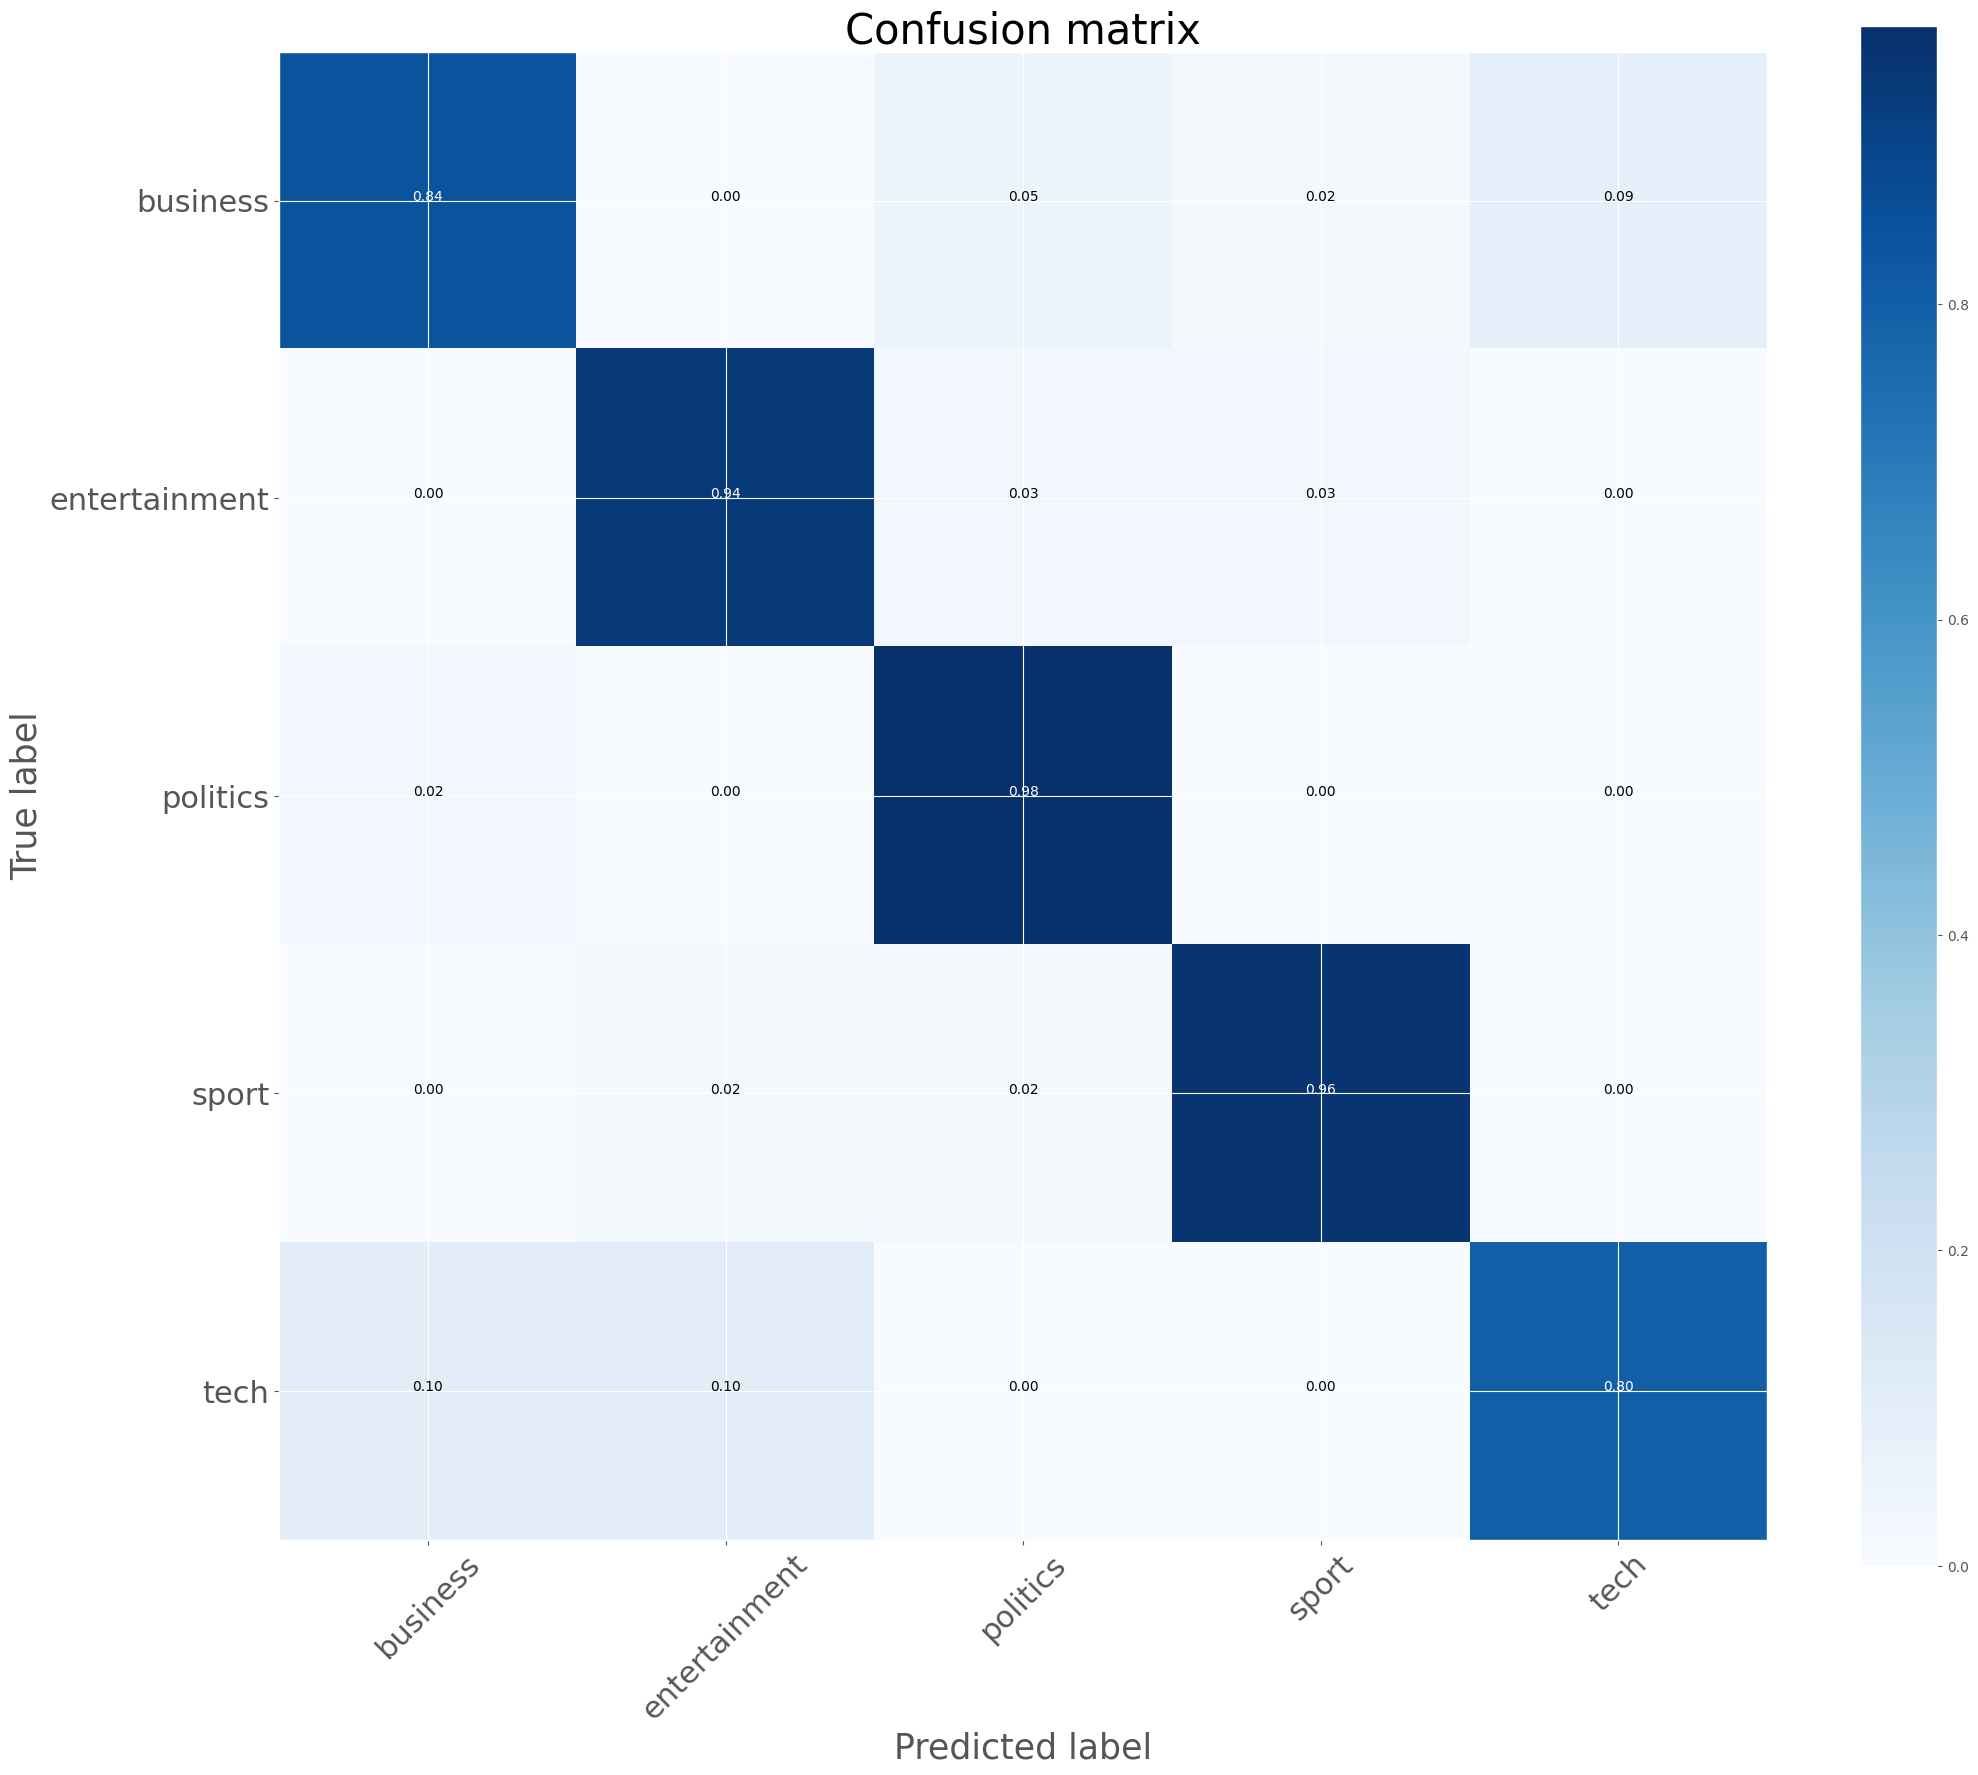

In [28]:
import itertools
cnf_matrix = confusion_matrix(y_true=true_labels, y_pred=pred_labels)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=list(labels.keys()), title="Confusion matrix")
plt.show()

In [29]:
torch.save(model.state_dict(), 'simple_gpt2_.pt')

In [30]:
def predict(text):
  model_new = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
  model_new.load_state_dict(torch.load("simple_gpt2_.pt"))
  model_new.eval()
  #test ="house prices show slight increase prices of homes in the uk rose a seasonally adjusted 0.5%"
  fixed_text = "".join(text.lower().split())
  tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
  tokenizer.padding_side = "left"
  tokenizer.pad_token = tokenizer.eos_token
  model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")
  mask = model_input['attention_mask'].cpu()
  input_id = model_input["input_ids"].cpu()

  output = model_new(input_id, mask)
  labels_map = {
    0: "business",
    1: "entertainment",
    2: "politics",
    3: "sport",
    4: "tech",
    }
  pred_label = labels_map[output.argmax(dim=1).item()]
  return pred_label

In [31]:
model_test = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
model_test.load_state_dict(torch.load("simple_gpt2_.pt"))
model_test.eval()

SimpleGPT2SequenceClassifier(
  (gpt2model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (fc1): Linear(in_features=98304, out_features=5, bias=True)
)

In [32]:
test = "house prices show slight increase prices of homes in the uk rose a seasonally adjusted 0.5%";
fixed_text = " ".join(test.lower().split())
print(fixed_text)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")

house prices show slight increase prices of homes in the uk rose a seasonally adjusted 0.5%


In [33]:
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].cpu()
output = model_test(input_id, mask)

In [34]:
print(output)

tensor([[-1.5847,  1.7195, -2.0726, -0.6836,  0.1081]],
       grad_fn=<AddmmBackward0>)


In [35]:

prob = torch.nn.functional.softmax(output, dim=1)[0]
print(prob)

tensor([0.0272, 0.7411, 0.0167, 0.0670, 0.1479], grad_fn=<SelectBackward0>)


In [36]:
test1 = "house prices show slight increase prices of homes in the uk rose a seasonally adjusted 0.5%"
print(predict(test1))

entertainment


In [37]:
test = "worldcom boss  left books alone  former worldcom boss bernie ebbers  who is accused of overseeing an $11bn (Â£5.8bn) fraud  never made accounting decisions  a witness has told jurors.  david myers made the comments under questioning by defence lawyers who have been arguing that mr ebbers was not responsible for worldcom s problems. the phone company collapsed in 2002 and prosecutors claim that losses were hidden to protect the firm s shares. mr myers has already pleaded guilty to fraud and is assisting prosecutors.  on monday  defence lawyer reid weingarten tried to distance his client from the allegations. during cross examination  he asked mr myers if he ever knew mr ebbers  make an accounting decision  .  not that i am aware of   mr myers replied.  did you ever know mr ebbers to make an accounting entry into worldcom books   mr weingarten pressed.  no   replied the witness. mr myers has admitted that he ordered false accounting entries at the request of former worldcom chief financial officer scott sullivan. defence lawyers have been trying to paint mr sullivan  who has admitted fraud and will testify later in the trial  as the mastermind behind worldcom s accounting house of cards.  mr ebbers  team  meanwhile  are looking to portray him as an affable boss  who by his own admission is more pe graduate than economist. whatever his abilities  mr ebbers transformed worldcom from a relative unknown into a $160bn telecoms giant and investor darling of the late 1990s. worldcom s problems mounted  however  as competition increased and the telecoms boom petered out. when the firm finally collapsed  shareholders lost about $180bn and 20 000 workers lost their jobs. mr ebbers  trial is expected to last two months and if found guilty the former ceo faces a substantial jail sentence. he has firmly declared his innocence.";
print(predict(test))

business
